# 2. Slug Test - Falling Head
**This test is taken from examples of AQTESOLV.**

## Step 1. Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3]
import pandas as pd
from ttim import *

## Introduction and Conceptual Model

In this notebook, we reproduce the work of Yang (2020) to check the TTim performance in analysing slug-test. We later compare the solution in TTim with the KGS analytical model (Hyder et al. 1994) implemented in AQTESOLV (Duffield, 2007).

This slug test was reported in Batu (1998). A well partially penetrates a sandy unconfined aquifer that has a saturated depth of 32.57 ft. The top of the screen is located 0.47 ft below the water table and has 13.8 ft in length. The well and casing radii are 5 and 2 inches, respectively.

The slug displacement is 1.48 ft. Head change has been recorded at the slug well.

The conceptual model is seen in the figure below.

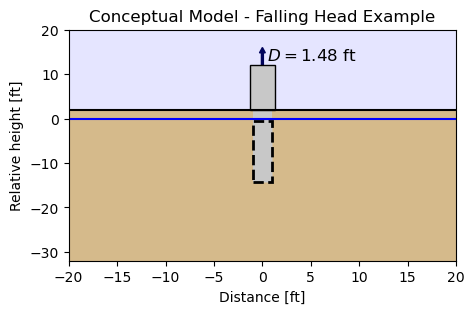

In [2]:
import matplotlib.pyplot as plt
import numpy as np

##Now printing the conceptual model figure:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# sky
sky = plt.Rectangle((-20, 2), width=50, height=20, fc="b", zorder=0, alpha=0.1)
ax.add_patch(sky)

# Aquifer:
ground = plt.Rectangle(
    (-20, -32.57),
    width=50,
    height=34.57,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(ground)

well = plt.Rectangle(
    (-1, -(0.47 + 13.8)),
    width=2,
    height=(0.47 + 13.8) + 2,
    fc=np.array([200, 200, 200]) / 255,
    zorder=1,
)
ax.add_patch(well)

# Wellhead
wellhead = plt.Rectangle(
    (-1.25, 2),
    width=2.5,
    height=10,
    fc=np.array([200, 200, 200]) / 255,
    zorder=2,
    ec="k",
)
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-1, -(0.47 + 13.8)),
    width=2,
    height=13.8,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x=0, y=10, dx=0, dy=6, color="#00035b")
ax.add_patch(pumping_arrow)
ax.text(x=0.5, y=13, s=r"$ D = 1.48$ ft", fontsize="large")

# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[2, 2], color="k")
ax.add_line(line)

# water table
line = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="blue")
ax.add_line(line)


ax.set_xlim([-20, 20])
ax.set_ylim([-32, 20])
ax.set_xlabel("Distance [ft]")
ax.set_ylabel("Relative height [ft]")
ax.set_title("Conceptual Model - Falling Head Example");

## Step 2. Set basic parameters

Parameters here declared are already converted from feet and inches to meters

In [3]:
rw = 0.127  # well radius
rc = 0.0508  # well casing radius
L = 4.20624  # screen length
b = -9.9274  # aquifer thickness
zt = -0.1433  # depth to top of the screen
H0 = 0.4511  # initial displacement in the well
zb = zt - L  # bottom of the screen

## Step 3. Converting slug displacement to volume

In [4]:
Q = np.pi * rc**2 * H0
print("Slug:", round(Q, 5), "m^3")

Slug: 0.00366 m^3


## Step 4. Load data

Drawdown data is available in feet and seconds and are converted to meters and days

In [5]:
data = np.loadtxt("data/falling_head.txt", skiprows=2)
t = data[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h = (10 - data[:, 1]) * 0.3048  # convert drawdown from ft to meters

## Step 5. Create First Model - three layers

We begin with a model with just three layers. We arranged the layers to match the screen length. The first layer is located just above the screen, the second layer is located at the screen depths, and the last layer is just below the screen, up to the total aquifer depth.

We set the model in the same manner as in [Slug 1 - Pratt County](slug1_pratt_county.ipynb).

In [6]:
ml_0 = Model3D(kaq=10, z=[0, zt, zb, b], Saq=1e-4, tmin=1e-5, tmax=0.01)
w_0 = Well(ml_0, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, -Q)], layers=1, wbstype="slug")
ml_0.solve()

self.neq  1
solution complete


## Step 6. Model calibration

The procedures for calibration can be seen in [Unconfined 1 - Vennebulten](unconfined1_vennebulten.ipynb)

We calibrate hydraulic conductivity and specific storage, as in the KGS model (Hyder et al. 1994).

In [7]:
ca_0 = Calibrate(ml_0)
ca_0.set_parameter(name="kaq0_2", initial=10)
ca_0.set_parameter(name="Saq0_2", initial=1e-4, pmin=1e-7)
ca_0.series(name="obs", x=0, y=0, t=t, h=h, layer=1)
ca_0.fit(report=True)

...............................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 27
    # variables        = 2
    chi-square         = 0.00114578
    reduced chi-square = 4.5831e-05
    Akaike info crit   = -267.822650
    Bayesian info crit = -265.230976
[[Variables]]
    kaq0_2:  0.59981087 +/- 0.03385855 (5.64%) (init = 10)
    Saq0_2:  2.0901e-04 +/- 6.5392e-05 (31.29%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_2, Saq0_2) = -0.9720


In [8]:
display(ca_0.parameters)
print("RMSE:", ca_0.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_2,0.599811,0.033859,5.644871,-inf,inf,10.0000,"[0.5998108693035121, 0.5998108693035121, 0.599..."
Saq0_2,0.000209,0.000065,31.286801,1.000000e-07,inf,0.0001,"[0.00020900772948173607, 0.0002090077294817360..."


RMSE: 0.006514317872522675


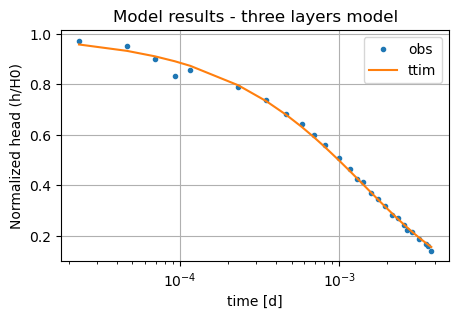

In [9]:
hm_0 = ml_0.head(0, 0, t, layers=1)
plt.semilogx(t, h / H0, ".", label="obs")
plt.semilogx(t, hm_0[0] / H0, label="ttim")
plt.xlabel("time [d]")
plt.ylabel("Normalized head (h/H0)")
plt.title("Model results - three layers model")
plt.legend()
plt.grid()

## Step 7. Create Second Model - multi-layer model

To investigate whether we can improve the model performance, we will create a multi-layer model. For this, we divide the previous second and third layers into 0.5 m thick layers:

In [10]:
# Determine elevation of each layer.
# Thickness of each layer is set to be 0.5 m.
z0 = np.arange(zt, zb, -0.5)
z1 = np.arange(zb, b, -0.5)
zlay = np.append(z0, z1)
zlay = np.append(zlay, b)
zlay = np.insert(zlay, 0, 0)
nlay = len(zlay) - 1  # number of layers
Saq_1 = 1e-4 * np.ones(nlay)
Saq_1[0] = 0.1

In [11]:
ml_1 = Model3D(
    kaq=10, z=zlay, Saq=Saq_1, kzoverkh=1, tmin=1e-5, tmax=0.01, phreatictop=True
)
w_1 = Well(
    ml_1,
    xw=0,
    yw=0,
    rw=rw,
    tsandQ=[(0, -Q)],
    layers=[1, 2, 3, 4, 5, 6, 7, 8],
    rc=rc,
    wbstype="slug",
)
ml_1.solve()

self.neq  8
solution complete


## Step 8. Calibration of multi-layer model

In [12]:
ca_1 = Calibrate(ml_1)
ca_1.set_parameter(name="kaq0_21", initial=10, pmin=0)
ca_1.set_parameter(name="Saq0_21", initial=1e-4, pmin=0)
ca_1.series(name="obs", x=0, y=0, layer=1, t=t, h=h)
ca_1.fit(report=True)

...................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 27
    # variables        = 2
    chi-square         = 0.00108524
    reduced chi-square = 4.3410e-05
    Akaike info crit   = -269.288333
    Bayesian info crit = -266.696659
[[Variables]]
    kaq0_21:  0.49534703 +/- 0.02256920 (4.56%) (init = 10)
    Saq0_21:  4.0607e-04 +/- 1.0398e-04 (25.61%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_21, Saq0_21) = -0.9593


In [13]:
display(ca_1.parameters)
print("RMSE:", ca_1.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_21,0.495347,0.022569,4.556241,0,inf,10.0000,"[0.4953470298678706, 0.4953470298678706, 0.495..."
Saq0_21,0.000406,0.000104,25.607619,0,inf,0.0001,"[0.00040606934369180614, 0.0004060693436918061..."


RMSE: 0.006339882457078611


RMSE has just slightly improved, and the parameter values are more or less similar to the previous values. However, AIC has improved significantly.

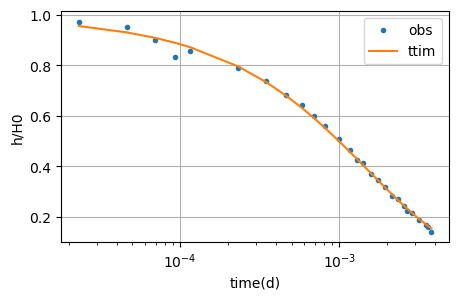

In [14]:
hm_1 = ml_1.head(0, 0, t, layers=8)
plt.semilogx(t, h / H0, ".", label="obs")
plt.semilogx(t, hm_1[0] / H0, label="ttim")
plt.xlabel("time(d)")
plt.ylabel("h/H0")
plt.legend()
plt.grid()

## Step 9. Final Model calibration with well skin resistance

Now we test if the skin resistance of the well has an impact on model calibration. For this, we add the ```res``` parameter in the calibration settings. We use the same multi-layer model.

In [15]:
ca_2 = Calibrate(ml_1)
ca_2.set_parameter(name="kaq0_21", initial=10, pmin=0)
ca_2.set_parameter(name="Saq0_21", initial=1e-4, pmin=0)
ca_2.set_parameter_by_reference(name="res", parameter=w_1.res, initial=0.1, pmin=0)
ca_2.series(name="obs", x=0, y=0, layer=1, t=t, h=h)
ca_2.fit(report=True)

...........................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 27
    # variables        = 3
    chi-square         = 0.00261618
    reduced chi-square = 1.0901e-04
    Akaike info crit   = -243.530660
    Bayesian info crit = -239.643150
[[Variables]]
    kaq0_21:  0.77614880 +/- 0.14548992 (18.75%) (init = 10)
    Saq0_21:  1.9868e-06 +/- 7.1794e-06 (361.36%) (init = 0.0001)
    res:      0.03586282 +/- 0.01085492 (30.27%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_21, Saq0_21) = -0.9951
    C(Saq0_21, res)     = -0.8114
    C(kaq0_21, res)     = +0.7922


In [16]:
display(ca_2.parameters)
print("RMSE:", ca_2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_21,0.776149,0.145490,18.745106,0,inf,10.0000,"[0.776148804286849, 0.776148804286849, 0.77614..."
Saq0_21,0.000002,0.000007,361.360601,0,inf,0.0001,"[1.9867660865369174e-06, 1.9867660865369174e-0..."
res,0.035863,0.010855,30.267890,0,inf,0.1000,[0.03586281612741771]


RMSE: 0.0098435569739182


The model has only improved slightly with the addition of the skin resistance, with a tiny improvement in AIC and RMSE. That indicates that skin resistance can be ignored in this situation.

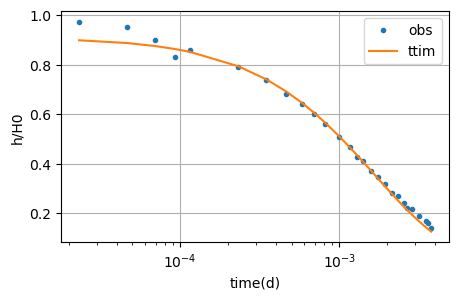

In [17]:
hm_2 = ml_1.head(0, 0, t, layers=8)
plt.semilogx(t, h / H0, ".", label="obs")
plt.semilogx(t, hm_2[0] / H0, label="ttim")
plt.xlabel("time(d)")
plt.ylabel("h/H0")
plt.legend()
plt.grid()

## Step 10. Analysis and comparison of simulated values

We now compare the values in TTim and add the results of the AQTESOLV modelling reported by Yang (2020).

In [18]:
ta = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "res [1/d]"],
    index=["AQTESOLV", "ttim-three", "ttim-multi", "ttim-res"],
)
ta.loc["ttim-three"] = np.concatenate((ca_0.parameters["optimal"].values, [np.nan]))
ta.loc["ttim-multi"] = np.concatenate((ca_1.parameters["optimal"].values, [np.nan]))
ta.loc["ttim-res"] = ca_2.parameters["optimal"].values
ta.loc["AQTESOLV"] = [2.616, 7.894e-5] + [np.nan]
ta["RMSE"] = [
    0.001197,
    round(ca_0.rmse(), 6),
    round(ca_1.rmse(), 6),
    round(ca_2.rmse(), 6),
]
ta.style.set_caption("Comparison of parameter values and error under different models")

,k [m/d],Ss [1/m],res [1/d],RMSE
AQTESOLV,2.616000,0.000079,nan,0.001197
ttim-three,0.599811,0.000209,nan,0.006514
ttim-multi,0.495347,0.000406,nan,0.017475
ttim-res,0.776149,0.000002,0.035863,0.009844


AQTESOLV parameters are quite different from the set parameters in TTim. It also has a better RMSE performance. All TTim models are very similar to each other. However, the multi-layer models performed better.

## References

* Batu, V., 1998. Aquifer hydraulics: a comprehensive guide to hydrogeologic data analysis. John Wiley & Sons
* Hyder, Z., Butler Jr, J.J., McElwee, C.D., Liu, W., 1994. Slug tests in partially penetrating wells. Water Resources Research 30, 2945–2957.
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.